## The Modeling Process

1. The train dataset has all of the columns that you will need to generate and refine your models. The test dataset has all of those columns except for the target that you are trying to predict in your Regression model.
2. Generate your regression model using the training data. We expect that within this process, you'll be making use of:
    - train-test split
    - cross-validation / grid searching for hyperparameters
    - strong exploratory data analysis to question correlation and relationship across predictive variables
    - code that reproducibly and consistently applies feature transformation (such as the preprocessing library)
3. Predict the values for your target column in the test dataset and submit your predictions to Kaggle to see how your model does against unknown data.
    - **Note**: Kaggle expects to see your submissions in a specific format. Check the challenge's page to make sure you are formatting your CSVs correctly!
    - **You are limited to models you've learned in class**. In other words, you cannot use XGBoost, Neural Networks or any other advanced model for this project.
4. Evaluate your models!
    - consider your evaluation metrics
    - consider your baseline score
    - how can your model be used for inference?
    - why do you believe your model will generalize to new data?
    
Your technical report will be hosted on Github Enterprise. Make sure it includes:

- [ ] A README.md (that isn't this file).
- [ ] Jupyter notebook(s) with your analysis and models (renamed to describe your project)
- [ ] At least three successful prediction submissions on [DSI-122 Regression Challenge](https://www.kaggle.com/competitions/dsi-122-ames-housing-challenge/overview) --  you should see your name in the "[Leaderboard](https://www.kaggle.com/competitions/dsi-122-ames-housing-challenge/leaderboard)" tab.
- [ ] Data files
- [ ] Presentation slides
- [ ] Any other necessary files (images, etc.)

# Import and Read-in Dataset

In [3]:
#import and read dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder 


pd.set_option('display.max_rows', 500)

df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [4]:
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


# Null/Baseline Model

In [6]:
# The most "basic" of prediction for sale price
df_test['SalePrice'] = df_train['SalePrice'].mean()

# Prep for submission
submission = df_test[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission.to_csv('submissions/baseline.csv')

# SLR Model (single x-var)

In [7]:
xvars = ['1st Flr SF']

# Arrange
X = df_train[xvars]
y = df_train['SalePrice']

# Train and Fit 
lr = LinearRegression()
lr.fit(X, y)

# Evaluate and Predict
lr.score(X, y) # R2 = 0.38252510667511996
preds = lr.predict(df_test[xvars])

# Prep for submission
preds.shape # (878,)
df_test['SalePrice'] = preds
submission = df_test[['Id', 'SalePrice']].set_index('Id')
submission.to_csv('submissions/slr_submission.csv')

# MLR (multiple x variables)
Including only numeric x-variables, with minimal cleaning.

In [8]:
xvars = [
#         'Id', 
#         'PID', 
#          'MS SubClass', 
#          'MS Zoning', 
         'Lot Frontage', 
         'Lot Area',
#          'Street', 
#          'Alley', 
#          'Lot Shape', 
#          'Land Contour', 
    
#          'Utilities',
            'Utilities_AllPub', 
            'Utilities_NoSeWa', 
            'Utilities_NoSewr',
    
#          'Lot Config', 
#          'Land Slope', 
#          'Neighborhood', 
#          'Condition 1',
#          'Condition 2',
    
#          'Bldg Type',
            'Bldg Type_1Fam',
            'Bldg Type_2fmCon',
            'Bldg Type_Duplex',
            'Bldg Type_Twnhs',
            'Bldg Type_TwnhsE',
    
    
#          'House Style', 
         'Overall Qual',
         'Overall Cond', 
         'Year Built', 
         'Year Remod/Add', 
#          'Roof Style',
#          'Roof Matl', 
#          'Exterior 1st', 
#          'Exterior 2nd', 
#          'Mas Vnr Type',
#          'Mas Vnr Area', 
         'Exter Qual', 
         'Exter Cond', 
#          'Foundation', 
#          'Bsmt Qual',
#          'Bsmt Cond', 
#          'Bsmt Exposure', 
#          'BsmtFin Type 1', 
#          'BsmtFin SF 1',
#          'BsmtFin Type 2', 
#          'BsmtFin SF 2', 
#          'Bsmt Unf SF', 
#          'Total Bsmt SF',
#          'Heating', 
#          'Heating QC', 
         'Central Air', 
#          'Electrical', 
         '1st Flr SF',
         '2nd Flr SF', 
#          'Low Qual Fin SF', 
#          'Gr Liv Area', 
#          'Bsmt Full Bath',
#          'Bsmt Half Bath', 
#          'Full Bath', 
#          'Half Bath', 
         'Bedroom AbvGr',
         'Kitchen AbvGr', 
#          'Kitchen Qual', 
#          'TotRms AbvGrd', 
#          'Functional',
         'Fireplaces',
         'Fireplace Qu', 
#          'Garage Type', 
         'Garage Yr Blt',
#          'Garage Finish', 
#          'Garage Cars', 
         'Garage Area', 
#          'Garage Qual',
#          'Garage Cond', 
#          'Paved Drive', 
#          'Wood Deck SF', 
#          'Open Porch SF',
#          'Enclosed Porch', 
#          '3Ssn Porch', 
#          'Screen Porch', 
         'Pool Area', 
#          'Pool QC',
#          'Fence', 
#          'Misc Feature', 
         'Misc Val', 
#          'Mo Sold', 
#          'Yr Sold', 
#          'Sale Type',
#          'SalePrice',
]

# EDA and Cleaning

In [9]:
df_train.columns
df_train.shape #(2051, 81)
df_train.describe()
df_train.dtypes
# realestate.info(verbose=True)
df_train.isna().sum()

Id                    0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        330
Lot Area              0
Street                0
Alley              1911
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type       1240
Mas Vnr Area         22
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            55
Bsmt Cond            55
Bsmt Exposure        58
BsmtFin Type 1       55
BsmtFin SF 1          1
BsmtFin Type 2       56
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC      

In [10]:
# Dummify
df_train['Central Air'] = np.where(df_train['Central Air'] == 'Y', 1, 0)
df_test['Central Air'] = np.where(df_test['Central Air'] == 'Y', 1, 0)

df_train = pd.get_dummies(df_train, columns=['Utilities', 'Bldg Type'], dtype=int)
df_test = pd.get_dummies(df_test, columns=['Utilities', 'Bldg Type'], dtype=int)
df_test['Utilities_NoSeWa'] = [0] * df_test.shape[0]


# ORDINAL MAPPING
ordinal_mapping = {
    np.nan: 0,
    'TA': 1,
    'Gd': 2,
    'Po': 3,
    'Ex': 4,
    'Fa': 5
}

# map
df_train['Fireplace Qu'] = df_train['Fireplace Qu'].map(ordinal_mapping)
df_test['Fireplace Qu'] = df_test['Fireplace Qu'].map(ordinal_mapping)

df_train['Exter Qual'] = df_train['Exter Qual'].map(ordinal_mapping)
df_test['Exter Qual'] = df_test['Exter Qual'].map(ordinal_mapping)

df_train['Exter Cond'] = df_train['Exter Cond'].map(ordinal_mapping)
df_test['Exter Cond'] = df_test['Exter Cond'].map(ordinal_mapping)




In [11]:

# Training Data
df_train = df_train[xvars + ['Id', 'SalePrice']]

df_train.isna().sum()
df_train = df_train.fillna(0)


# Testing Data
df_test = df_test[xvars + ['Id']]

df_test.isna().sum()
df_test = df_test.fillna(0)






In [12]:
# sns.pairplot(df_train)

# TTS & CV

In [13]:
# Arrange
X = df_train[xvars]
y = df_train['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)

# Preprocessing
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)

# Train and Fit 



lr = LinearRegression()

print("X_train cross val score:", cross_val_score(lr, X_train, y_train, cv=5).mean())
print("X_test cross val score:", cross_val_score(lr, X_test, y_test, cv=5).mean())



## TTS
lr.fit(X_train_sc, y_train)



# # Evaluate
score = lr.score(X, y)
score_tr = lr.score(X_train_sc, y_train)
score_val = lr.score(X_val_sc, y_val)

print("score: ", score) # R2 = 0.8094765027052091, 0.8115395609699825 w/ Porches SF, better here
print("score_tr: ", score_tr)
print("score_val: ", score_val)


# Predict
preds = lr.predict(df_test[xvars])

#### Prep for submission
preds.shape # (878,)
df_test['SalePrice'] = preds
submission = df_test[['Id', 'SalePrice']].set_index('Id')
now = datetime.now().strftime("%m%d_%H%M%S")
submission.to_csv(f'submissions/mlr_subm_{now}_{score_val}.csv')

X_train cross val score: 0.8213256035913463


NameError: name 'X_test' is not defined

# Lasso Regression (_chosen model_)

In [15]:
# Arrange
X = df_train[xvars]
y = df_train['SalePrice']



X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)

# Preprocessing
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)

# Train and Fit 
# lr = LinearRegression()

# cross_val_score(lr, X, y, cv=5)
# print("X cross val score:", cross_val_score(lr, X, y, cv=5).mean())

lasso_cv = LassoCV(n_alphas=100, cv=8, max_iter=50_000)
lasso_cv.fit(X_train_sc, y_train)
lasso_cv.alpha_
print("X_train LASSO Score: ", lasso_cv.score(X_train_sc, y_train))
print("X_val LASSO Score: ", lasso_cv.score(X_val_sc, y_val))


my_df = pd.DataFrame(zip(df_train.columns, lasso_cv.coef_))
# my_df = my_df.columns.sort_values()
print(my_df)
## TTS
# lr.fit(X_train_sc, y_train)



# # # Evaluate
# score = lr.score(X, y)
# score_tr = lr.score(X_train_sc, y_train)
# score_val = lr.score(X_val_sc, y_val)

# print("score: ", score) # R2 = 0.8094765027052091, 0.8115395609699825 w/ Porches SF, better here
# print("score_tr: ", score_tr)
# print("score_val: ", score_val)


# Predict
# preds = lr.predict(df_test[xvars])
preds = lasso_cv.predict(df_test[xvars])
print("X_test LASSO Score: ", lasso_cv.score(df_test[xvars], preds))


### Prep for submission
# print(preds.shape) # (878,)
df_test['SalePrice'] = preds


# submission = df_test[['Id', 'SalePrice']].set_index('Id')
# now = datetime.now().strftime("%m%d_%H%M%S")
# submission.to_csv(f'submissions/mlr_subm_{now}_{score_val}.csv')

X_train LASSO Score:  0.850990357614428
X_val LASSO Score:  0.7029568152372263
                   0             1
0       Lot Frontage   2639.233617
1           Lot Area   5498.048102
2   Utilities_AllPub    636.411575
3   Utilities_NoSeWa     -0.000000
4   Utilities_NoSewr     -0.000000
5     Bldg Type_1Fam   3063.281062
6   Bldg Type_2fmCon      0.000000
7   Bldg Type_Duplex      0.000000
8    Bldg Type_Twnhs   -791.574410
9   Bldg Type_TwnhsE   -305.383363
10      Overall Qual  23343.934536
11      Overall Cond   5986.121939
12        Year Built  10736.421540
13    Year Remod/Add   2348.395078
14        Exter Qual  12540.318394
15        Exter Cond  -1447.984001
16       Central Air      0.000000
17        1st Flr SF  30372.612799
18        2nd Flr SF  20787.653227
19     Bedroom AbvGr  -3985.131605
20     Kitchen AbvGr  -2322.574298
21        Fireplaces   4691.953860
22      Fireplace Qu    890.535003
23     Garage Yr Blt  -3249.100161
24       Garage Area  10094.794476
25         

C:\Users\T\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
C:\Users\T\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


''

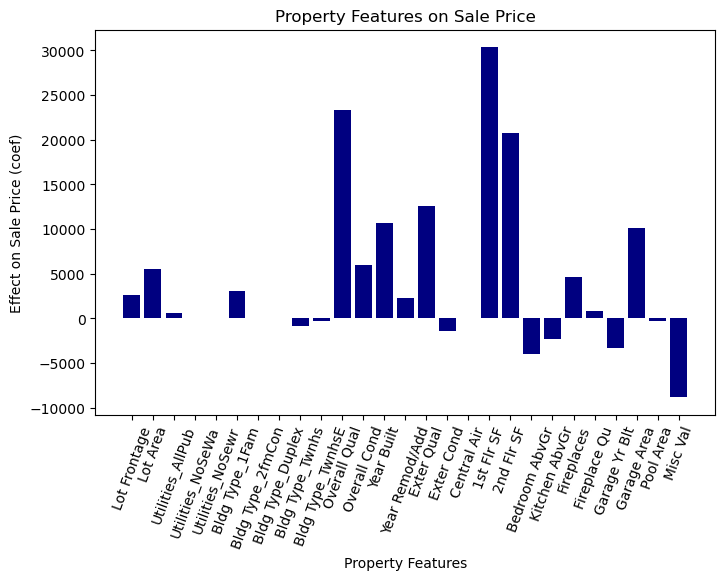

In [37]:
# x_catg = ['Lot Area', 'Bldg Type_1Fam', '1st Flr SF']
# my_df.loc(my_df[x_catg])
plt.figure(figsize=(8,5))
plt.bar(my_df[0], my_df[1], color='navy', alpha=1)
plt.title('Property Features on Sale Price')
plt.xlabel('Property Features')
plt.ylabel('Effect on Sale Price (coef)')
plt.xticks(rotation=70)
;


# 1           Lot Area   5498.048102 - 5
# 5     Bldg Type_1Fam   3063.281062 - 6
# 17        1st Flr SF  30,372.612799 - 1


# 24       Garage Area  10,094.794476 - 4
# 2   Utilities_AllPub    636.411575 medium effecgt, convience. - 7
# 10      Overall Qual  23,343.934536 - 2
# 14        Exter Qual  12,540.318394 - 3


# Ridge 

In [160]:
# Arrange
X = df_train[xvars]
y = df_train['SalePrice']



X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)

# Preprocessing
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)

# Train and Fit 
ridge_model = Ridge(alpha=0)
ridge_model.fit(X_train_sc, y_train)

#eval
print("Xtrain", ridge_model.score(X_train_sc, y_train))
print("Xval", ridge_model.score(X_val_sc, y_val))

#preds
preds = ridge_model.predict(df_test[xvars])
print("Xtest", ridge_model.score(df_test[xvars], preds))




# cross_val_score(lr, X, y, cv=5)
# print("X cross val score:", cross_val_score(lr, X, y, cv=5).mean())

# lasso_cv = LassoCV(n_alphas=100, cv=8, max_iter=50_000)
# lasso_cv.fit(X_train_sc, y_train)
# lasso_cv.alpha_
# print("X_train LASSO Score: ", lasso_cv.score(X_train_sc, y_train))
# print("X_val LASSO Score: ", lasso_cv.score(X_val_sc, y_val))

# ## TTS
# # lr.fit(X_train_sc, y_train)



# # # Evaluate
# score = lr.score(X, y)
# score_tr = lr.score(X_train_sc, y_train)
# score_val = lr.score(X_val_sc, y_val)

# print("score: ", score) # R2 = 0.8094765027052091, 0.8115395609699825 w/ Porches SF, better here
# print("score_tr: ", score_tr)
# print("score_val: ", score_val)


# Predict
# # preds = lr.predict(df_test[xvars])
# preds = lasso_cv.predict(df_test[xvars])
# print("X_test LASSO Score: ", lasso_cv.score(df_test[xvars], preds))


### Prep for submission
# print(preds.shape) # (878,)
df_test['SalePrice'] = preds


submission = df_test[['Id', 'SalePrice']].set_index('Id')
now = datetime.now().strftime("%m%d_%H%M%S")
submission.to_csv(f'submissions/mlr_subm_{now}_{score_val}.csv')

Xtrain 0.8504883265121909
Xval 0.6803449023715474
Xtest 1.0


C:\Users\T\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\T\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


array([[ 0.93588966,  0.72317324, -0.79459841, ..., -0.45362089,
        -0.06893331, -0.09221167],
       [ 0.25438571,  0.48593745, -0.79459841, ...,  0.43697292,
        -0.06893331, -0.09221167],
       [ 0.53318278, -0.22243055, -0.79459841, ...,  0.38131081,
        -0.06893331, -0.09221167],
       ...,
       [-0.45809569,  0.26651173,  0.58240706, ...,  0.31637168,
        -0.06893331, -0.09221167],
       [ 0.16145335,  0.3447091 ,  0.58240706, ...,  0.21432447,
        -0.06893331, -0.09221167],
       [ 0.34731807, -0.17108744, -0.79459841, ...,  1.24407356,
        -0.06893331, -0.09221167]])

In [ ]:
# Interpret
'''
R2 = 0.8094765027052091, 0.8115395609699825 w/ Porches SF, better 
kaggle score = 34838, vs 34974
Better R2 Value with (x vars below), but worse overall in Kaggle
#          'Wood Deck SF', 
#          'Open Porch SF',

score_tr:  0.82890749060673
score_test:  0.6904955294972794

high variance. 


with CV_score is MSE - a loss function, lower number is better. 

initial scores:
cross val score: 0.7892739684953172
shows a poor overall model

score:  0.8031073115152962
score_tr:  0.82890749060673
score_test:  0.6904955294972794
The TTS diff shows there is high variance and overfitting. Therefore we need to "fix" by  doing a poly transform for better fit
or use a LASSO Regularization to help with the overfitting.



X_poly degree 4, 2 is worse: very high overfitting
X cross val score: 0.7892739684953172
X_poly cross val score: -0.7497069831931212
score:  0.8051059078217057
score_tr:  0.9165158143139792
score_test:  0.3333213067923606


Good model, terrible actual serving data
X_train LASSO Score:  0.8275763304912442
X_val LASSO Score:  0.7048586534656807



df_test does not have any properties that contain 'Utilities_NoSeWa' value
'''

'0214_174141'

'0214_173942'

In [50]:
# EDA
df_train.columns
df_train.shape #(2051, 81)
df_train.describe()
df_train.dtypes
# realestate.info(verbose=True)
df_train.isna().sum()

;

''

In [4]:
# # Clean Data

# print("df train", df_train.shape)

# df_train_num = df_train.select_dtypes(include='number')
# print("df_train_num", df_train_num.shape)

# df_train_num = df_train_num.fillna(0)
# print("df_train_num no na", df_train_num.shape)

# #####

# print("df test", df_test.shape)

# df_test_num = df_test.select_dtypes(include='number')
# print("df_test_num", df_test_num.shape)

# df_test_num = df_test_num.fillna(0)
# print("df_test_num no na", df_test_num.shape)

In [5]:
# Preliminary plots and correlation heatmaps and correlation tables, multicollinearity

In [7]:
# Baseline <copy from breakfast hour>

In [187]:
# # OLS
# X = df_train.drop(columns=['SalePrice'])
# X_test = df_test_num
# print(df_test_num.shape) 
# y = df_train['SalePrice']

# ols = LinearRegression()
# ols.fit(X, y)

# print("X_train score:", ols.score(X,y))
# print("X_train score:", ols.score(X,y))
# # ols.predict()

# preds = ols.predict(X_serving)
# X_serving['SalePrice'] = preds

# X_serving.shape # (2051, 38
# preds.shape #(2051,)
# X_serving.head()



# ols_submission = X_serving[['Id', 'SalePrice']]
# ols_submission.set_index('Id', inplace=True) 
# ols_submission.to_csv('submissions/ols_submission.csv')

In [ ]:
# Train-Test Split / k-fold cross validation
'''
Adding the train-test split allows us to check the balance between bias/variance \
Allows us to tune the model without resubmitting to kaggle infinitely.

Do K-fold but if its too slow, go back to train-test spilt

'''

In [3]:
# cross-validation

In [ ]:
# polynomial fits?